In [59]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [60]:
#data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
#!wget $data

Check if the missing values are presented in the features.

In [61]:
df = pd.read_csv('course_lead_scoring.csv')
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [62]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

For caterogiral features, replace them with 'NA'.

For numerical features, replace with with 0.0

In [63]:
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features]= df[categorical_features].fillna('NA')

numerical_features = df.select_dtypes(include=['number']).columns
df[numerical_features]= df[numerical_features].fillna(0.0)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.

In [64]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train,df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Ectract the desired target for classification

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

numerical_features= numerical_features.drop(['converted'])


Question 1. ROC AUC feature importance

In [65]:
from sklearn.metrics import roc_auc_score

for numerical in numerical_features:
    score = roc_auc_score(y_train,df_train[numerical])
    if score<0.5:
        #df_train[numerical]=-df_train[numerical]
        score = roc_auc_score(y_train,(-df_train[numerical]))
    print("the AUC score for the ",numerical,"is: ",score)


the AUC score for the  number_of_courses_viewed is:  0.7635680590007088
the AUC score for the  annual_income is:  0.5519578313253012
the AUC score for the  interaction_count is:  0.738270176293409
the AUC score for the  lead_score is:  0.6144993577250176


number_of_courses_viewed has the highest AUC.

In [66]:
numerical_features= numerical_features.tolist()
categorical_features = categorical_features.tolist()

Question 2. Model AUC 

In [67]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression



train_dicts = df_train[categorical_features+ numerical_features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

#the AUC of this model on the validation dataset

roc_auc = roc_auc_score(y_val, y_pred)
print("the AUC score on the validation dataset is: ", round(roc_auc,3))

the AUC score on the validation dataset is:  0.817


Question 3. Precision and recall 

/tmp/ipykernel_2209/3417463812.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


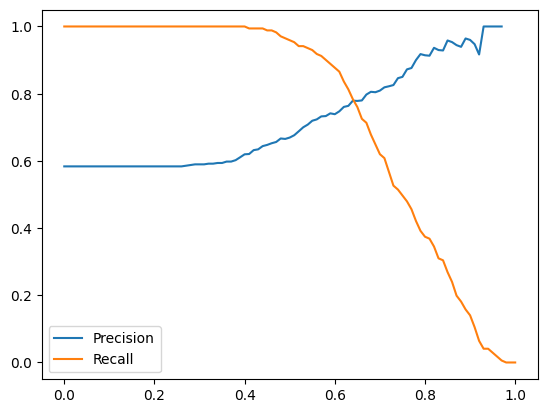

In [68]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds  = np.linspace(0, 1, 101) #thresholds from 0 to 1 with step 0.01
prediction = []
recall = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    prediction.append(p)
    recall.append(r)

plt.plot(thresholds, prediction, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.legend()

Question 4: F1 score

In [69]:
F1 = (2 * (np.array(prediction) * np.array(recall))) / (np.array(prediction) + np.array(recall))

In [70]:
F1_threshold = thresholds[F1.argmax()]

print(F1_threshold)

0.98


Question 5: 5-Fold CV

In [71]:
from sklearn.model_selection import KFold

In [72]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_features + numerical_features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [73]:
def predict(df, dv, model):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [74]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


Question 6: Hyperparameter Tuning

In [75]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [76]:
from tqdm.auto import tqdm

In [77]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s   %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

100%|██████████| 3/3 [00:00<00:00, 12.06it/s]

C=1e-06   0.822 +- 0.036
C=0.001   0.822 +- 0.036
C=1   0.822 +- 0.036
